## Máster en Big Data y Data Science

### Metodologías de gestión y diseño de proyectos de big data

#### AP2 - Modelado y evaluación

---

En esta libreta se realiza la experimentación para generación del modelo de predicción objetivo del proyecto y la evaluación del mismo.
La versión del dataset a utilizar es la obtenida a partir de las operaciones de transformación.

In [3]:
# Se importan las librerías necesarias y se suprimen las advertencias
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=UserWarning)

In [4]:
# Lectura de los datos
df = pd.read_csv('../data/processed/bank-additional-transformed.csv')
df.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,contacted_before
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no


In [5]:
# Se divide el dataset en variables predictoras y variable objetivo
X = df.drop('y', axis=1)
y = df['y']

In [6]:
# Se genera el conjunto de entrenamiento y prueba con estratificación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [7]:
# Se separan las columnas numéricas
numerical_columns=X_train.select_dtypes(exclude='object').columns
display(numerical_columns)

categorical_columns=X_train.select_dtypes(include='object').columns
display(categorical_columns)

Index(['age', 'duration', 'campaign', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')

Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome', 'contacted_before'],
      dtype='object')

In [8]:
# Se verifica la distribución de la variable objetivo en el conjunto de entrenamiento
y_train.value_counts()

y
0    27190
1     3406
Name: count, dtype: int64

In [9]:
# Se crea un pipeline para preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler  

# Pipeline para valores numéricos
num_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

# Pipeline para valores categóricos
cat_pipeline = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(drop='first',sparse_output=False))
])

# Se configuran los preprocesadores
preprocessor_full = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_columns),
    ('cat_pipeline', cat_pipeline, categorical_columns)
]).set_output(transform='pandas')

In [10]:
preprocessor_train_valid = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_columns),
    ('cat_pipeline', cat_pipeline, categorical_columns)
]).set_output(transform='pandas')

In [11]:
# Se ajusta y transforma el conjunto de entrenamiento y prueba
x_train_prep = preprocessor_full.fit_transform(X_train)
x_test_prep = preprocessor_full.transform(X_test)

In [12]:
# Se aplica submuestreo a los datos preprocesados
from sklearn.utils import resample

# Combinar los datos preprocesados con las etiquetas
train_data = x_train_prep.copy()
train_data['target'] = y_train.reset_index(drop=True)

# Separar por clase
class_0 = train_data[train_data['target'] == 0]
class_1 = train_data[train_data['target'] == 1]

# Encontrar la clase minoritaria
min_count = min(len(class_0), len(class_1))

# Submuestreo balanceado - tomar una muestra igual al tamaño de la clase minoritaria
class_0_balanced = resample(class_0, n_samples=min_count, random_state=42)
class_1_balanced = resample(class_1, n_samples=min_count, random_state=42)

# Combinar las clases balanceadas
balanced_data = pd.concat([class_0_balanced, class_1_balanced])

# Separar características y objetivo
x_train_resampled = balanced_data.drop('target', axis=1)
y_train_resampled = balanced_data['target']

print(f"Tamaño original: {len(x_train_prep)}")
print(f"Tamaño balanceado: {len(x_train_resampled)}")
print(f"Distribución balanceada: {y_train_resampled.value_counts()}")

Tamaño original: 30596
Tamaño balanceado: 5450
Distribución balanceada: target
0.0    2725
1.0    2725
Name: count, dtype: int64


In [13]:
from sklearn.model_selection import cross_val_score


# Se genera una función para realizar validación cruzada
def cross_val(model):
    scores = cross_val_score(model,x_train_resampled , y_train_resampled, cv=5, scoring='f1')
    print('cross validation f1 scores',scores*100)
    print('cross validation f1 mean',scores.mean()*100)
    print('cross validation f1 std',scores.std())
    print('-'*50)
    scores = cross_val_score(model,x_train_resampled , y_train_resampled, cv=5, scoring='recall')
    print('cross validation recall scores',scores*100)
    print('cross validation recall mean',scores.mean()*100)
    print('cross validation recall std',scores.std())

In [14]:
# Se aplica un modelo de regresión logística
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1,penalty='l2',solver='liblinear',random_state=1,max_iter=100,tol=0.000000001)

# cross validation scores
cross_val(lr)

cross validation f1 scores [47.68946396 51.57116451 49.29709466 49.5412844  50.72727273]
cross validation f1 mean 49.76525605093318
cross validation f1 std 0.0132401153018114
--------------------------------------------------
cross validation recall scores [47.33944954 51.19266055 48.25688073 49.5412844  51.19266055]
cross validation recall mean 49.50458715596331
cross validation recall std 0.01545646949625883


In [15]:
# LinearSVC
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=10000,tol=0.001)

# cross validation scores
cross_val(svc)

cross validation f1 scores [47.75022957 51.84501845 50.27932961 49.72273567 50.77343039]
cross validation f1 mean 50.07414873869516
cross validation f1 std 0.01355814515763869
--------------------------------------------------
cross validation recall scores [47.70642202 51.55963303 49.5412844  49.35779817 51.19266055]
cross validation recall mean 49.871559633027516
cross validation recall std 0.013896584388081803


In [16]:
# knclassifier
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=7)

# cross validation scores
cross_val(knc)

cross validation f1 scores [60.0896861  57.96579658 59.35030729 54.34583715 57.96579658]
cross validation f1 mean 57.94348473810715
cross validation f1 std 0.019763296183430562
--------------------------------------------------
cross validation recall scores [61.46788991 59.08256881 62.01834862 54.49541284 59.08256881]
cross validation recall mean 59.22935779816514
cross validation recall std 0.02654913357458485


In [17]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()

# cross validation scores
cross_val(tree)

cross validation f1 scores [70.83685545 69.40874036 69.59517657 70.68965517 72.26596675]
cross validation f1 mean 70.5592788621255
cross validation f1 std 0.010256765940153307
--------------------------------------------------
cross validation recall scores [75.41284404 72.66055046 74.67889908 75.2293578  75.41284404]
cross validation recall mean 74.6788990825688
cross validation recall std 0.010444219795051512


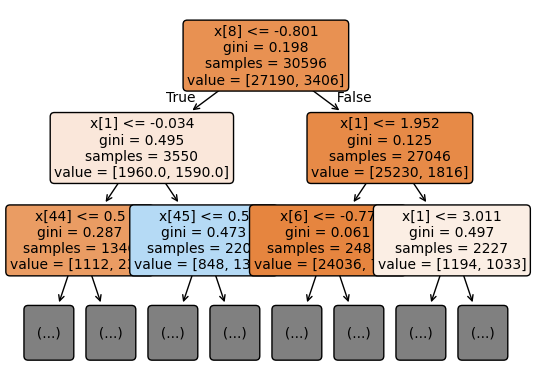

In [18]:
# decision tree plot
from sklearn.tree import plot_tree
tree.fit(x_train_prep, y_train)
plot_tree(tree, filled=True, rounded=True,max_depth=2,fontsize=10)
plt.show()

In [19]:
# Se obtiene la matriz de confusión para el modelo
from sklearn.metrics import confusion_matrix

y_pred = tree.predict(x_test_prep)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[6372  425]
 [ 421  431]]


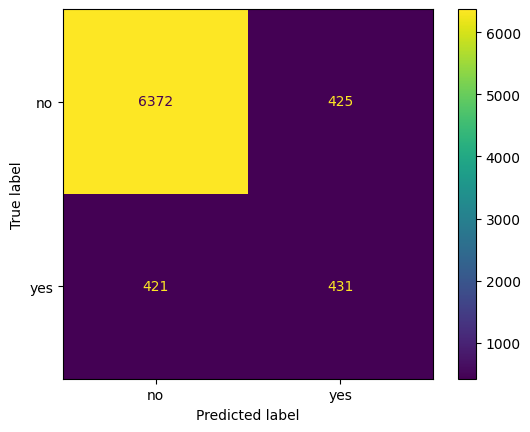

In [20]:
# Se visualiza la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot()

#### Predicción con datos nuevos (sin clasificar)

In [21]:
df_nuevos = pd.read_csv('../data/processed/bank-additional-new.csv')
df_nuevos.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,contacted_before
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN


In [22]:
# Diagnosticar el problema con los nuevos datos
print("Información del conjunto de datos nuevos:")
print(f"Forma: {df_nuevos.shape}")
print("\nTipos de datos:")
print(df_nuevos.dtypes)
print("\nValores nulos:")
print(df_nuevos.isnull().sum())
print("\nColumnas categóricas en nuevos datos:")
print(df_nuevos.select_dtypes(include='object').columns.tolist())
print("\nColumnas numéricas en nuevos datos:")
print(df_nuevos.select_dtypes(exclude='object').columns.tolist())

Información del conjunto de datos nuevos:
Forma: (9, 20)

Tipos de datos:
age                   int64
job                  object
marital              object
education            object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
previous              int64
poutcome             object
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                    object
contacted_before    float64
dtype: object

Valores nulos:
age                 0
job                 0
marital             0
education           0
housing             0
loan                0
contact             0
month               0
day_of_week         0
duration            0
campaign            0
previous            0
poutcome            0
emp_var_rate        0
cons_price_idx      0
cons_c

In [24]:
# Comparar con los datos de entrenamiento originales
print("Comparación de columnas:")
print(f"Columnas en datos originales: {list(X.columns)}")
print(f"Columnas en datos nuevos: {list(df_nuevos.columns)}")

print("\nColumnas que están en nuevos pero no en originales:")
new_cols = set(df_nuevos.columns) - set(X.columns)
print(new_cols)

print("\nColumnas que están en originales pero no en nuevos:")
missing_cols = set(X.columns) - set(df_nuevos.columns)
print(missing_cols)

Comparación de columnas:
Columnas en datos originales: ['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'contacted_before']
Columnas en datos nuevos: ['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'contacted_before']

Columnas que están en nuevos pero no en originales:
{'y'}

Columnas que están en originales pero no en nuevos:
set()


In [27]:
# Se hace la predicción con los nuevos datos
# Primero, eliminar la columna objetivo si existe y preparar las características
X_new = df_nuevos.drop('y', axis=1) if 'y' in df_nuevos.columns else df_nuevos.copy()

# Asegurar que las columnas estén en el mismo orden que en el entrenamiento
X_new = X_new[X.columns]

# Manejar la columna contacted_before para que coincida con el formato de entrenamiento
# En entrenamiento: 'no', 'yes' (string)
# En nuevos datos: NaN -> necesita convertirse a 'no' (asumiendo que NaN significa no contactado)
X_new['contacted_before'] = X_new['contacted_before'].fillna('no')

# Convertir cualquier valor numérico a string si es necesario
if X_new['contacted_before'].dtype in ['float64', 'int64']:
    X_new['contacted_before'] = X_new['contacted_before'].map({0.0: 'no', 1.0: 'yes'}).fillna('no')

# Asegurar que contacted_before sea de tipo object como en entrenamiento
X_new['contacted_before'] = X_new['contacted_before'].astype('object')

# Transformar los nuevos datos usando el mismo preprocesador y predecir
try:
    x_new_prep = preprocessor_full.transform(X_new)
    
    y_new_pred = tree.predict(x_new_prep)
    print(f"\nPredicciones: {y_new_pred}")
    
    predictions_df = pd.DataFrame({
        'Cliente': range(1, len(y_new_pred) + 1),
        'Predicción_Numérica': y_new_pred,
        'Suscribirá': ['No' if pred == 0 else 'Sí' for pred in y_new_pred]
    })
    print("\nResultados detallados:")
    print(predictions_df.to_string(index=False))
    
    # Resumen de predicciones
    pred_counts = pd.Series(y_new_pred).value_counts()
    print("\nResumen de predicciones:")
    for pred_val, count in pred_counts.items():
        label = 'No realizará un depósito' if pred_val == 0 else 'Sí realizará un depósito'
        print(f"  {label}: {count} clientes ({count/len(y_new_pred)*100:.1f}%)")
    
except Exception as e:
    print(f"Error durante el preprocesamiento o predicción: {e}")
    print("Información adicional para depuración:")
    print(f"Tipos de datos en X_new:\n{X_new.dtypes}")


Predicciones: [0 0 0 0 0 0 0 1 1]

Resultados detallados:
 Cliente  Predicción_Numérica Suscribirá
       1                    0         No
       2                    0         No
       3                    0         No
       4                    0         No
       5                    0         No
       6                    0         No
       7                    0         No
       8                    1         Sí
       9                    1         Sí

Resumen de predicciones:
  No realizará un depósito: 7 clientes (77.8%)
  Sí realizará un depósito: 2 clientes (22.2%)
